
What Can Transformers Learn In-Context? A Case Study of Simple Function Classes

Shivam Garg*, Dimitris Tsipras*, Percy Liang, Gregory Valiant

Paper: http://arxiv.org/abs/2208.01066


https://github.com/dtsip/in-context-learning.git


#Prerequisites

tested on Python 3.10 with a T4 GPU

In [1]:
%%capture
!pip install -q matplotlib==3.5.2 numpy==1.22.3 pandas==1.4.2 scikit-learn==1.0.2 seaborn==0.11.2 tqdm==4.64.0 transformers==4.17.0 wandb==0.12.11 xgboost==1.6.1 protobuf==3.20.1 torch==2.1.0+cu118

#Config


In [2]:
class args_c():
    class wandb_c():
        def __init__(self):             # wandb
            self.project = "in-context-learning"
            self.name = "linear_regression_toy"
            self.entity = "your-entity"
            self.notes = ""
            self.log_every_steps = 100

    class model_c():
        def __init__(self):             # model
            self.family = "gpt2"
            self.n_embd = 256
            self.n_layer = 12
            self.n_head = 8
            # toy: n_dims = 5, n_positions = 11
            # full: n_dims = 20, n_positions = 101
            self.n_dims = 11
            self.n_positions = 49

    class training_c():
        class curriculum_c():
            class dims_c():
                def __init__(self):     # dims
                    self.start = 5
                    self.end = 11
                    self.inc = 1
                    self.interval = 2000

            class points_c():
                def __init__(self):     # points
                    self.start = 11
                    self.end = 49
                    self.inc = 2
                    self.interval = 2000

            def __init__(self):         # curriculum
                self.dims = self.dims_c()
                self.points = self.points_c()

        def __init__(self):             # training
            self.task = "decreasing_degree_polynomial_regression"                 # "fixed_degree_polynomial_regression", "decreasing_degree_polynomial_regression"
            self.data = "gaussian"
            self.task_kwargs = {"degree":1}
            self.num_tasks = None
            self.num_training_examples = None
            self.batch_size = 64
            self.learning_rate = .0001
            self.save_every_steps = 1000
            self.keep_every_steps = 100000
            self.train_steps = 40001
            self.resume_id = None

            self.curriculum = self.curriculum_c()

    def __init__(self):                 # args
        self.wandb = self.wandb_c()
        self.model = self.model_c()
        self.training = self.training_c()

        self.out_dir = "./models/test"
        self.test_run = False
        self.using_wandb = False

args = args_c()

#Model

In [3]:
import torch
import torch.nn as nn
from transformers import GPT2Model, GPT2Config
from tqdm import tqdm
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression, Lasso
import warnings
from sklearn import tree
import xgboost as xgb

In [4]:
def build_model(conf):
    if conf.family == "gpt2":
        model = TransformerModel(
            n_dims=conf.n_dims,
            n_positions=conf.n_positions,
            n_embd=conf.n_embd,
            n_layer=conf.n_layer,
            n_head=conf.n_head,
        )
    else:
        raise NotImplementedError

    return model


def get_relevant_baselines(task_name):
    task_to_baselines = {
        "fixed_degree_polynomial_regression": [
            (LeastSquaresModel, {}),
            (NNModel, {"n_neighbors": 3}),
            (DecisionTreeModel, {"max_depth": 4}),
            (DecisionTreeModel, {"max_depth": None}),
            (XGBoostModel, {}),
            (AveragingModel, {}),
        ],
        "decreasing_degree_polynomial_regression": [
            (LeastSquaresModel, {}),
            (NNModel, {"n_neighbors": 3}),
            (DecisionTreeModel, {"max_depth": 4}),
            (DecisionTreeModel, {"max_depth": None}),
            (XGBoostModel, {}),
            (AveragingModel, {}),
        ]
    }

    models = [model_cls(**kwargs) for model_cls, kwargs in task_to_baselines[task_name]]
    return models


class NeuralNetwork(nn.Module):
    def __init__(self, in_size=50, hidden_size=1000, out_size=1):
        super(NeuralNetwork, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size),
        )

    def forward(self, x):
        out = self.net(x)
        return out


class ParallelNetworks(nn.Module):
    def __init__(self, num_models, model_class, **model_class_init_args):
        super(ParallelNetworks, self).__init__()
        self.nets = nn.ModuleList(
            [model_class(**model_class_init_args) for i in range(num_models)]
        )

    def forward(self, xs):
        assert xs.shape[0] == len(self.nets)

        for i in range(len(self.nets)):
            out = self.nets[i](xs[i])
            if i == 0:
                outs = torch.zeros(
                    [len(self.nets)] + list(out.shape), device=out.device
                )
            outs[i] = out
        return outs

class TransformerModel(nn.Module):
    def __init__(self, n_dims, n_positions, n_embd=128, n_layer=12, n_head=4):
        super(TransformerModel, self).__init__()
        configuration = GPT2Config(
            n_positions=2 * n_positions,
            n_embd=n_embd,
            n_layer=n_layer,
            n_head=n_head,
            resid_pdrop=0.0,
            embd_pdrop=0.0,
            attn_pdrop=0.0,
            use_cache=False,
        )
        self.name = f"gpt2_embd={n_embd}_layer={n_layer}_head={n_head}"

        self.n_positions = n_positions
        self.n_dims = n_dims
        self._read_in = nn.Linear(n_dims, n_embd)
        self._backbone = GPT2Model(configuration)
        self._read_out = nn.Linear(n_embd, 1)

    @staticmethod
    def _combine(xs_b, ys_b):
        """Interleaves the x's and the y's into a single sequence."""
        bsize, points, dim = xs_b.shape
        ys_b_wide = torch.cat(
            (
                ys_b.view(bsize, points, 1),
                torch.zeros(bsize, points, dim - 1, device=ys_b.device),
            ),
            axis=2,
        )
        zs = torch.stack((xs_b, ys_b_wide), dim=2)
        zs = zs.view(bsize, 2 * points, dim)
        return zs

    def forward(self, xs, ys, inds=None):
        if inds is None:
            inds = torch.arange(ys.shape[1])
        else:
            inds = torch.tensor(inds)
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")
        zs = self._combine(xs, ys)
        embeds = self._read_in(zs)
        output = self._backbone(inputs_embeds=embeds).last_hidden_state
        prediction = self._read_out(output)
        return prediction[:, ::2, 0][:, inds]  # predict only on xs


class NNModel:
    def __init__(self, n_neighbors, weights="uniform"):
        # should we be picking k optimally
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.name = f"NN_n={n_neighbors}_{weights}"

    def __call__(self, xs, ys, inds=None):
        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []

        for i in inds:
            if i == 0:
                preds.append(torch.zeros_like(ys[:, 0]))  # predict zero for first point
                continue
            train_xs, train_ys = xs[:, :i], ys[:, :i]
            test_x = xs[:, i : i + 1]
            dist = (train_xs - test_x).square().sum(dim=2).sqrt()

            if self.weights == "uniform":
                weights = torch.ones_like(dist)
            else:
                weights = 1.0 / dist
                inf_mask = torch.isinf(weights).float()  # deal with exact match
                inf_row = torch.any(inf_mask, axis=1)
                weights[inf_row] = inf_mask[inf_row]

            pred = []
            k = min(i, self.n_neighbors)
            ranks = dist.argsort()[:, :k]
            for y, w, n in zip(train_ys, weights, ranks):
                y, w = y[n], w[n]
                pred.append((w * y).sum() / w.sum())
            preds.append(torch.stack(pred))

        return torch.stack(preds, dim=1)


# xs and ys should be on cpu for this method. Otherwise the output maybe off in case when train_xs is not full rank due to the implementation of torch.linalg.lstsq.
class LeastSquaresModel:
    def __init__(self, driver=None):
        self.driver = driver
        self.name = f"OLS_driver={driver}"

    def __call__(self, xs, ys, inds=None):
        xs, ys = xs.cpu(), ys.cpu()
        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []

        for i in inds:
            if i == 0:
                preds.append(torch.zeros_like(ys[:, 0]))  # predict zero for first point
                continue
            train_xs, train_ys = xs[:, :i], ys[:, :i]
            test_x = xs[:, i : i + 1]

            ws, _, _, _ = torch.linalg.lstsq(
                train_xs, train_ys.unsqueeze(2), driver=self.driver
            )

            pred = test_x @ ws
            preds.append(pred[:, 0, 0])

        return torch.stack(preds, dim=1)


class AveragingModel:
    def __init__(self):
        self.name = "averaging"

    def __call__(self, xs, ys, inds=None):
        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []

        for i in inds:
            if i == 0:
                preds.append(torch.zeros_like(ys[:, 0]))  # predict zero for first point
                continue
            train_xs, train_ys = xs[:, :i], ys[:, :i]
            test_x = xs[:, i : i + 1]

            train_zs = train_xs * train_ys.unsqueeze(dim=-1)
            w_p = train_zs.mean(dim=1).unsqueeze(dim=-1)
            pred = test_x @ w_p
            preds.append(pred[:, 0, 0])

        return torch.stack(preds, dim=1)


# Lasso regression (for sparse linear regression).
# Seems to take more time as we decrease alpha.
class LassoModel:
    def __init__(self, alpha, max_iter=100000):
        # the l1 regularizer gets multiplied by alpha.
        self.alpha = alpha
        self.max_iter = max_iter
        self.name = f"lasso_alpha={alpha}_max_iter={max_iter}"

    # inds is a list containing indices where we want the prediction.
    # prediction made at all indices by default.
    def __call__(self, xs, ys, inds=None):
        xs, ys = xs.cpu(), ys.cpu()

        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []  # predict one for first point

        # i: loop over num_points
        # j: loop over bsize
        for i in inds:
            pred = torch.zeros_like(ys[:, 0])

            if i > 0:
                pred = torch.zeros_like(ys[:, 0])
                for j in range(ys.shape[0]):
                    train_xs, train_ys = xs[j, :i], ys[j, :i]

                    # If all points till now have the same label, predict that label.

                    clf = Lasso(
                        alpha=self.alpha, fit_intercept=False, max_iter=self.max_iter
                    )

                    # Check for convergence.
                    with warnings.catch_warnings():
                        warnings.filterwarnings("error")
                        try:
                            clf.fit(train_xs, train_ys)
                        except Warning:
                            print(f"lasso convergence warning at i={i}, j={j}.")
                            raise

                    w_pred = torch.from_numpy(clf.coef_).unsqueeze(1)

                    test_x = xs[j, i : i + 1]
                    y_pred = (test_x @ w_pred.float()).squeeze(1)
                    pred[j] = y_pred[0]

            preds.append(pred)

        return torch.stack(preds, dim=1)


# Gradient Descent and variants.
# Example usage: gd_model = GDModel(NeuralNetwork, {'in_size': 50, 'hidden_size':400, 'out_size' :1}, opt_alg = 'adam', batch_size = 100, lr = 5e-3, num_steps = 200)
class GDModel:
    def __init__(
        self,
        model_class,
        model_class_args,
        opt_alg="sgd",
        batch_size=1,
        num_steps=1000,
        lr=1e-3,
        loss_name="squared",
    ):
        # model_class: torch.nn model class
        # model_class_args: a dict containing arguments for model_class
        # opt_alg can be 'sgd' or 'adam'
        # verbose: whether to print the progress or not
        # batch_size: batch size for sgd
        self.model_class = model_class
        self.model_class_args = model_class_args
        self.opt_alg = opt_alg
        self.lr = lr
        self.batch_size = batch_size
        self.num_steps = num_steps
        self.loss_name = loss_name

        self.name = f"gd_model_class={model_class}_model_class_args={model_class_args}_opt_alg={opt_alg}_lr={lr}_batch_size={batch_size}_num_steps={num_steps}_loss_name={loss_name}"

    def __call__(self, xs, ys, inds=None, verbose=False, print_step=100):
        # inds is a list containing indices where we want the prediction.
        # prediction made at all indices by default.
        # xs: bsize X npoints X ndim.
        # ys: bsize X npoints.
        xs, ys = xs.cuda(), ys.cuda()

        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []  # predict one for first point

        # i: loop over num_points
        for i in tqdm(inds):
            pred = torch.zeros_like(ys[:, 0])
            model = ParallelNetworks(
                ys.shape[0], self.model_class, **self.model_class_args
            )
            model.cuda()
            if i > 0:
                pred = torch.zeros_like(ys[:, 0])

                train_xs, train_ys = xs[:, :i], ys[:, :i]
                test_xs, test_ys = xs[:, i : i + 1], ys[:, i : i + 1]

                if self.opt_alg == "sgd":
                    optimizer = torch.optim.SGD(model.parameters(), lr=self.lr)
                elif self.opt_alg == "adam":
                    optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
                else:
                    raise NotImplementedError(f"{self.opt_alg} not implemented.")

                if self.loss_name == "squared":
                    loss_criterion = nn.MSELoss()
                else:
                    raise NotImplementedError(f"{self.loss_name} not implemented.")

                # Training loop
                for j in range(self.num_steps):

                    # Prepare batch
                    mask = torch.zeros(i).bool()
                    perm = torch.randperm(i)
                    mask[perm[: self.batch_size]] = True
                    train_xs_cur, train_ys_cur = train_xs[:, mask, :], train_ys[:, mask]

                    if verbose and j % print_step == 0:
                        model.eval()
                        with torch.no_grad():
                            outputs = model(train_xs_cur)
                            loss = loss_criterion(
                                outputs[:, :, 0], train_ys_cur
                            ).detach()
                            outputs_test = model(test_xs)
                            test_loss = loss_criterion(
                                outputs_test[:, :, 0], test_ys
                            ).detach()
                            print(
                                f"ind:{i},step:{j}, train_loss:{loss.item()}, test_loss:{test_loss.item()}"
                            )

                    optimizer.zero_grad()

                    model.train()
                    outputs = model(train_xs_cur)
                    loss = loss_criterion(outputs[:, :, 0], train_ys_cur)
                    loss.backward()
                    optimizer.step()

                model.eval()
                pred = model(test_xs).detach()

                assert pred.shape[1] == 1 and pred.shape[2] == 1
                pred = pred[:, 0, 0]

            preds.append(pred)

        return torch.stack(preds, dim=1)


class DecisionTreeModel:
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.name = f"decision_tree_max_depth={max_depth}"

    # inds is a list containing indices where we want the prediction.
    # prediction made at all indices by default.
    def __call__(self, xs, ys, inds=None):
        xs, ys = xs.cpu(), ys.cpu()

        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []

        # i: loop over num_points
        # j: loop over bsize
        for i in inds:
            pred = torch.zeros_like(ys[:, 0])

            if i > 0:
                pred = torch.zeros_like(ys[:, 0])
                for j in range(ys.shape[0]):
                    train_xs, train_ys = xs[j, :i], ys[j, :i]

                    clf = tree.DecisionTreeRegressor(max_depth=self.max_depth)
                    clf = clf.fit(train_xs, train_ys)
                    test_x = xs[j, i : i + 1]
                    y_pred = clf.predict(test_x)
                    pred[j] = y_pred[0]

            preds.append(pred)

        return torch.stack(preds, dim=1)


class XGBoostModel:
    def __init__(self):
        self.name = "xgboost"

    # inds is a list containing indices where we want the prediction.
    # prediction made at all indices by default.
    def __call__(self, xs, ys, inds=None):
        xs, ys = xs.cpu(), ys.cpu()

        if inds is None:
            inds = range(ys.shape[1])
        else:
            if max(inds) >= ys.shape[1] or min(inds) < 0:
                raise ValueError("inds contain indices where xs and ys are not defined")

        preds = []

        # i: loop over num_points
        # j: loop over bsize
        for i in tqdm(inds):
            pred = torch.zeros_like(ys[:, 0])
            if i > 0:
                pred = torch.zeros_like(ys[:, 0])
                for j in range(ys.shape[0]):
                    train_xs, train_ys = xs[j, :i], ys[j, :i]

                    clf = xgb.XGBRegressor()

                    clf = clf.fit(train_xs, train_ys)
                    test_x = xs[j, i : i + 1]
                    y_pred = clf.predict(test_x)
                    pred[j] = y_pred[0].item()

            preds.append(pred)

        return torch.stack(preds, dim=1)

#Samplers


In [5]:
import math

import torch

In [6]:
class DataSampler:
    def __init__(self, n_dims):
        self.n_dims = n_dims

    def sample_xs(self):
        raise NotImplementedError


def get_data_sampler(data_name, n_dims, **kwargs):
    names_to_classes = {
        "gaussian": GaussianSampler,
    }
    if data_name in names_to_classes:
        sampler_cls = names_to_classes[data_name]
        return sampler_cls(n_dims, **kwargs)
    else:
        print("Unknown sampler")
        raise NotImplementedError


def sample_transformation(eigenvalues, normalize=False):
    n_dims = len(eigenvalues)
    U, _, _ = torch.linalg.svd(torch.randn(n_dims, n_dims))
    t = U @ torch.diag(eigenvalues) @ torch.transpose(U, 0, 1)
    if normalize:
        norm_subspace = torch.sum(eigenvalues**2)
        t *= math.sqrt(n_dims / norm_subspace)
    return t


class GaussianSampler(DataSampler):
    def __init__(self, n_dims, bias=None, scale=None):
        super().__init__(n_dims)
        self.bias = bias
        self.scale = scale

    def sample_xs(self, n_points, b_size, n_dims_truncated=None, seeds=None):
        if seeds is None:
            # xs_b = torch.randn(b_size, n_points, self.n_dims).normal_(0, args.training.sampler_variance)
            xs_b = torch.randn(b_size, n_points, self.n_dims)
        else:
            # xs_b = torch.zeros(b_size, n_points, self.n_dims).normal_(0, args.training.sampler_variance)
            xs_b = torch.randn(b_size, n_points, self.n_dims)
            generator = torch.Generator()
            assert len(seeds) == b_size
            for i, seed in enumerate(seeds):
                generator.manual_seed(seed)
                # xs_b[i] = torch.randn(n_points, self.n_dims, generator=generator).normal_(0, args.training.sampler_variance)
                xs_b[i] = torch.randn(n_points, self.n_dims, generator=generator)
        if self.scale is not None:
            xs_b = xs_b @ self.scale
        if self.bias is not None:
            xs_b += self.bias
        if n_dims_truncated is not None:
            xs_b[:, :, n_dims_truncated:] = 0
        return xs_b

#Tasks

In [7]:
import math

import torch

In [31]:
def squared_error(ys_pred, ys):
    return (ys - ys_pred).square()


def mean_squared_error(ys_pred, ys):
    return (ys - ys_pred).square().mean()


def accuracy(ys_pred, ys):
    return (ys == ys_pred.sign()).float()


sigmoid = torch.nn.Sigmoid()
bce_loss = torch.nn.BCELoss()


def cross_entropy(ys_pred, ys):
    output = sigmoid(ys_pred)
    target = (ys + 1) / 2
    return bce_loss(output, target)


class Task:
    def __init__(self, n_dims, batch_size, pool_dict=None, seeds=None):
        self.n_dims = n_dims
        self.b_size = batch_size
        self.pool_dict = pool_dict
        self.seeds = seeds
        assert pool_dict is None or seeds is None

    def evaluate(self, xs):
        raise NotImplementedError

    @staticmethod
    def generate_pool_dict(n_dims, num_tasks):
        raise NotImplementedError

    @staticmethod
    def get_metric():
        raise NotImplementedError

    @staticmethod
    def get_training_metric():
        raise NotImplementedError


def get_task_sampler(
    task_name, n_dims, batch_size, pool_dict=None, num_tasks=None, **kwargs
):
    task_names_to_classes = {
        "fixed_degree_polynomial_regression": FixedDegreePolynomialRegression,
        "decreasing_degree_polynomial_regression": DecreasingDegreePolynomialRegression,
    }
    if task_name in task_names_to_classes:
        task_cls = task_names_to_classes[task_name]
        if num_tasks is not None:
            if pool_dict is not None:
                raise ValueError("Either pool_dict or num_tasks should be None.")
            pool_dict = task_cls.generate_pool_dict(n_dims, num_tasks, **kwargs)
        return lambda **args: task_cls(n_dims, batch_size, pool_dict, **args, **kwargs)
    else:
        print("Unknown task")
        raise NotImplementedError


class LinearRegression(Task):
    def __init__(self, n_dims, batch_size, pool_dict=None, seeds=None, scale=1):
        """scale: a constant by which to scale the randomly sampled weights."""
        super(LinearRegression, self).__init__(n_dims, batch_size, pool_dict, seeds)
        self.scale = scale

        if pool_dict is None and seeds is None:
            self.w_b = torch.randn(self.b_size, self.n_dims, 1)
        elif seeds is not None:
            self.w_b = torch.zeros(self.b_size, self.n_dims, 1)
            generator = torch.Generator()
            assert len(seeds) == self.b_size
            for i, seed in enumerate(seeds):
                generator.manual_seed(seed)
                self.w_b[i] = torch.randn(self.n_dims, 1, generator=generator)
        else:
            assert "w" in pool_dict
            indices = torch.randperm(len(pool_dict["w"]))[:batch_size]
            self.w_b = pool_dict["w"][indices]

    def evaluate(self, xs_b):
        w_b = self.w_b.to(xs_b.device)
        ys_b = self.scale * (xs_b @ w_b)[:, :, 0]
        return ys_b

    @staticmethod
    def generate_pool_dict(n_dims, num_tasks, **kwargs):  # ignore extra args
        return {"w": torch.randn(num_tasks, n_dims, 1)}

    @staticmethod
    def get_metric():
        return squared_error

    @staticmethod
    def get_training_metric():
        return mean_squared_error

class FixedDegreePolynomialRegression(LinearRegression):
    def __init__(
        self,
        n_dims,
        batch_size,
        pool_dict=None,
        seeds=None,
        scale = 1,
        degree = 2,
    ):
        super(FixedDegreePolynomialRegression, self).__init__(n_dims, batch_size, pool_dict, seeds, scale)
        self.degree = degree

    def evaluate(self, xs_b):
        w_b = self.w_b.to(xs_b.device)
        ys_b_d = ((xs_b**self.degree) @ w_b)[:, :, 0]
        # ys_b_quad = ys_b_quad * math.sqrt(self.n_dims) / ys_b_quad.std()
        # Renormalize to Linear Regression Scale
        ys_b_d = ys_b_d * math.sqrt(self.n_dims) / ys_b_d.std()
        ys_b_d = self.scale * ys_b_d
        return ys_b_d

class DecreasingDegreePolynomialRegression(LinearRegression):
    def __init__(
        self,
        n_dims,
        batch_size,
        pool_dict=None,
        seeds=None,
        scale = 1,
        degree = 2,
    ):
        super(DecreasingDegreePolynomialRegression, self).__init__(n_dims, batch_size, pool_dict, seeds, scale)
        self.degree = degree
        if pool_dict is None and seeds is None:
            self.w_b = torch.randn(self.b_size, self.n_dims, degree+1)
        elif seeds is not None:
            self.w_b = torch.zeros(self.b_size, self.n_dims, degree+1)
            generator = torch.Generator()
            assert len(seeds) == self.b_size
            for i, seed in enumerate(seeds):
                generator.manual_seed(seed)
                self.w_b[i] = torch.randn(self.n_dims, degree+1, generator=generator)
        else:
            assert "w" in pool_dict
            indices = torch.randperm(len(pool_dict["w"]))[:batch_size]
            self.w_b = pool_dict["w"][indices]


    def evaluate(self, xs_b):
        w_b = self.w_b.to(xs_b.device)
        powers_of_xs = [xs_b ** i for i in range(self.degree+1)]

        # powers_of_xs = torch.stack(powers_of_xs, dim=3)
        ys_b_k = 0
        for i in range(self.degree + 1):
            ys_b_k += (powers_of_xs[i] @ (w_b[:, :, i].unsqueeze(-1)))[:, :, 0]

        #         ys_b_quad = ys_b_quad * math.sqrt(self.n_dims) / ys_b_quad.std()
        # Renormalize to Linear Regression Scale
        # ys_b_k = ys_b_k / math.sqrt(self.degree+1)
        ys_b_k = ys_b_k * math.sqrt(self.n_dims) / ys_b_k.std()
        ys_b_k = self.scale * ys_b_k
        return ys_b_k

#Curriculum

In [9]:
import math

In [10]:
class Curriculum:
    def __init__(self, args):
        # args.dims and args.points each contain start, end, inc, interval attributes
        # inc denotes the change in n_dims,
        # this change is done every interval,
        # and start/end are the limits of the parameter
        self.n_dims_truncated = args.dims.start
        self.n_points = args.points.start
        self.n_dims_schedule = args.dims
        self.n_points_schedule = args.points
        self.step_count = 0

    def update(self):
        self.step_count += 1
        self.n_dims_truncated = self.update_var(
            self.n_dims_truncated, self.n_dims_schedule
        )
        self.n_points = self.update_var(self.n_points, self.n_points_schedule)

    def update_var(self, var, schedule):
        if self.step_count % schedule.interval == 0:
            var += schedule.inc

        return min(var, schedule.end)


# returns the final value of var after applying curriculum.
def get_final_var(init_var, total_steps, inc, n_steps, lim):
    final_var = init_var + math.floor((total_steps) / n_steps) * inc

    return min(final_var, lim)

#Evaluation Metrics

In [11]:
import json
import os
import sys

import numpy as np
import pandas as pd
from tqdm import tqdm
import torch

In [12]:
def get_model_from_run(run_path, step=-1, only_conf=False):
    conf = args
    if only_conf:
        return None, conf

    model = build_model(conf.model)

    if step == -1:
        state_path = os.path.join(run_path, "state.pt")
        state = torch.load(state_path)
        model.load_state_dict(state["model_state_dict"])
    else:
        model_path = os.path.join(run_path, f"model_{step}.pt")
        state_dict = torch.load(model_path)
        model.load_state_dict(state_dict)

    return model, conf


# Functions for evaluation


def eval_batch(model, task_sampler, xs, xs_p=None):
    task = task_sampler()
    if torch.cuda.is_available() and model.name.split("_")[0] in ["gpt2", "lstm"]:
        device = "cuda"
    else:
        device = "cpu"

    if xs_p is None:
        ys = task.evaluate(xs)
        pred = model(xs.to(device), ys.to(device)).detach()
        metrics = task.get_metric()(pred.cpu(), ys)
    else:
        b_size, n_points, _ = xs.shape
        metrics = torch.zeros(b_size, n_points)
        for i in range(n_points):
            xs_comb = torch.cat((xs[:, :i, :], xs_p[:, i:, :]), dim=1)
            ys = task.evaluate(xs_comb)

            pred = model(xs_comb.to(device), ys.to(device), inds=[i]).detach()
            metrics[:, i] = task.get_metric()(pred.cpu(), ys)[:, i]

    return metrics


# Functions for generating different kinds of train/test data


def gen_standard(data_sampler, n_points, b_size):
    xs = data_sampler.sample_xs(n_points, b_size)

    return xs, None


def gen_opposite_quadrants(data_sampler, n_points, b_size):
    xs = data_sampler.sample_xs(n_points, b_size)
    pattern = torch.randn([b_size, 1, xs.shape[2]]).sign()

    xs_train_pre = xs.abs() * pattern
    xs_test_post = -xs_train_pre

    return xs_train_pre, xs_test_post


def gen_random_quadrants(data_sampler, n_points, b_size):
    xs = data_sampler.sample_xs(n_points, b_size)
    pattern = torch.randn([b_size, 1, xs.shape[2]]).sign()

    xs_train_pre = xs.abs() * pattern
    xs_test_post = xs

    return xs_train_pre, xs_test_post


def gen_orthogonal_train_test(data_sampler, n_points, b_size):
    xs = data_sampler.sample_xs(n_points, b_size)
    n_dim = xs.shape[2]
    n_points = min(n_points, n_dim)
    # raise ValueError("number of points should be at most the dimension.")
    xs_train_pre = xs
    xs_test_post = torch.zeros(xs.shape)
    for i in range(n_points):
        xs_test_post_i = xs[:, i : i + 1, :]
        xs_train_pre_i = xs[:, :i, :]
        _, _, Vt = torch.linalg.svd(xs_train_pre_i, full_matrices=False)
        xs_train_pre_i_projection = Vt.transpose(1, 2) @ Vt
        xs_test_post_i_orthogonalized = (
            xs_test_post_i - xs_test_post_i @ xs_train_pre_i_projection
        )
        xs_test_post_i_normalized = (
            xs_test_post_i_orthogonalized
            * xs_test_post_i.norm(dim=2).unsqueeze(2)
            / xs_test_post_i_orthogonalized.norm(dim=2).unsqueeze(2)
        )

        xs_test_post[:, i : i + 1, :] = xs_test_post_i_normalized

    return xs_train_pre, xs_test_post


def gen_overlapping_train_test(data_sampler, n_points, b_size):
    xs = data_sampler.sample_xs(n_points, b_size)
    xs_train_pre = xs
    xs_test_post = xs.clone()
    b_size = xs.shape[0]
    for i in range(1, n_points):
        xs_train_pre_i = xs[:, :i, :]
        perm = torch.stack([torch.randperm(i) for _ in range(b_size)]).unsqueeze(dim=1)
        ind_mat = (perm == 0) + 0.0
        xs_test_post[:, i : i + 1, :] = ind_mat @ xs_train_pre_i

    return xs_train_pre, xs_test_post


def aggregate_metrics(metrics, bootstrap_trials=1000):
    """
    Takes as input a tensor of shape (num_eval, n_points) and returns a dict with
    per-point mean, stddev, and bootstrap limits
    """
    results = {}
    results["mean"] = metrics.mean(dim=0)
    results["std"] = metrics.std(dim=0, unbiased=True)
    n = len(metrics)
    bootstrap_indices = torch.randint(n, size=(bootstrap_trials, n))
    bootstrap_means = metrics[bootstrap_indices].mean(dim=1).sort(dim=0)[0]
    results["bootstrap_low"] = bootstrap_means[int(0.05 * bootstrap_trials), :]
    results["bootstrap_high"] = bootstrap_means[int(0.95 * bootstrap_trials), :]

    return {k: v.tolist() for k, v in results.items()}


def eval_model(
    model,
    task_name,
    data_name,
    n_dims,
    n_points,
    prompting_strategy,
    num_eval_examples=1280,
    batch_size=64,
    data_sampler_kwargs={},
    task_sampler_kwargs={},
):
    """
    Evaluate a model on a task with a variety of strategies.
       Args:
       - task: which base task we are evaluating on. E.g., "linear_regression"
       - prompting_strategy: how to construct the prompt, e.g., "random_quadrants"
       - num_eval_examples: total number of examples to evaluate on
       - **sampler_kwargs: remaining arguments to pass directly to the sampler
    """

    assert num_eval_examples % batch_size == 0
    data_sampler = get_data_sampler(data_name, n_dims, **data_sampler_kwargs)
    task_sampler = get_task_sampler(
        task_name, n_dims, batch_size, **task_sampler_kwargs
    )

    all_metrics = []

    generating_func = globals()[f"gen_{prompting_strategy}"]
    for i in range(num_eval_examples // batch_size):
        xs, xs_p = generating_func(data_sampler, n_points, batch_size)

        metrics = eval_batch(model, task_sampler, xs, xs_p)
        all_metrics.append(metrics)

    metrics = torch.cat(all_metrics, dim=0)

    return aggregate_metrics(metrics)


def build_evals(conf):
    n_dims = conf.model.n_dims
    n_points = conf.training.curriculum.points.end
    batch_size = conf.training.batch_size

    task_name = conf.training.task
    data_name = conf.training.data

    base_kwargs = {
        "task_name": task_name,
        "n_dims": n_dims,
        "n_points": n_points,
        "batch_size": batch_size,
        "data_name": data_name,
        "prompting_strategy": "standard",
    }

    evaluation_kwargs = {}

    evaluation_kwargs["standard"] = {"prompting_strategy": "standard"}
    if task_name != "linear_regression":
        if task_name in ["relu_2nn_regression"]:
            evaluation_kwargs["linear_regression"] = {"task_name": "linear_regression"}
        for name, kwargs in evaluation_kwargs.items():
            # allow kwargs to override base_kwargs values
            evaluation_kwargs[name] = base_kwargs.copy()
            evaluation_kwargs[name].update(kwargs)
        return evaluation_kwargs

    for strategy in [
        "random_quadrants",
        "orthogonal_train_test",
        "overlapping_train_test",
    ]:
        evaluation_kwargs[strategy] = {"prompting_strategy": strategy}

    for method in ["half_subspace", "skewed"]:
        if "subspace" in method:
            eigenvals = torch.zeros(n_dims)
            eigenvals[: n_dims // 2] = 1
        else:
            eigenvals = 1 / (torch.arange(n_dims) + 1)

        scale = sample_transformation(eigenvals, normalize=True)
        evaluation_kwargs[f"{method}"] = {
            "data_sampler_kwargs": {"scale": scale},
        }

    for dim in ["x", "y"]:
        for scale in [0.333, 0.5, 2, 3]:
            if dim == "x":
                eigenvals = scale * torch.ones(n_dims)
                t = sample_transformation(eigenvals)
                scaling_args = {"data_sampler_kwargs": {"scale": t}}
            else:
                eigenvals = scale * torch.ones(n_dims)
                scaling_args = {"task_sampler_kwargs": {"scale": scale}}

            evaluation_kwargs[f"scale-{dim}={scale}"] = scaling_args

    evaluation_kwargs[f"noisyLR"] = {
        "task_sampler_kwargs": {"renormalize_ys": True, "noise_std": 1},
        "task_name": "noisy_linear_regression",
    }

    for name, kwargs in evaluation_kwargs.items():
        # allow kwargs to override base_kwargs values
        evaluation_kwargs[name] = base_kwargs.copy()
        evaluation_kwargs[name].update(kwargs)

    return evaluation_kwargs


def compute_evals(all_models, evaluation_kwargs, save_path=None, recompute=False):
    try:
        with open(save_path) as fp:
            all_metrics = json.load(fp)
    except Exception:
        all_metrics = {}

    for eval_name, kwargs in tqdm(evaluation_kwargs.items()):
        metrics = {}
        if eval_name in all_metrics and not recompute:
            metrics = all_metrics[eval_name]
        for model in all_models:
            if model.name in metrics and not recompute:
                continue

            metrics[model.name] = eval_model(model, **kwargs)
        all_metrics[eval_name] = metrics

    if save_path is not None:
        with open(save_path, "w") as fp:
            json.dump(all_metrics, fp, indent=2)

    return all_metrics


def get_run_metrics(
    run_path, step=-1, cache=True, skip_model_load=False, skip_baselines=False
):
    if skip_model_load:
        _, conf = get_model_from_run(run_path, only_conf=True)
        all_models = []
    else:
        model, conf = get_model_from_run(run_path, step)
        model = model.cuda().eval()
        all_models = [model]
        if not skip_baselines:
            all_models += get_relevant_baselines(conf.training.task)
    evaluation_kwargs = build_evals(conf)

    if not cache:
        save_path = None
    elif step == -1:
        save_path = os.path.join(run_path, "metrics.json")
    else:
        save_path = os.path.join(run_path, f"metrics_{step}.json")

    recompute = False
    if save_path is not None and os.path.exists(save_path):
        checkpoint_created = os.path.getmtime(run_path)
        cache_created = os.path.getmtime(save_path)
        if checkpoint_created > cache_created:
            recompute = True

    all_metrics = compute_evals(all_models, evaluation_kwargs, save_path, recompute)
    return all_metrics



def conf_to_model_name(conf):
    if conf.model.family == "gpt2":
        return {
            (3, 2): "Transformer-xs",
            (6, 4): "Transformer-small",
            (12, 8): "Transformer",
        }[(conf.model.n_layer, conf.model.n_head)]
    else:
        return conf.wandb.name


def baseline_names(name):
    if "OLS" in name:
        return "Least Squares"
    if name == "averaging":
        return "Averaging"
    if "NN" in name:
        k = name.split("_")[1].split("=")[1]
        return f"{k}-Nearest Neighbors"
    if "lasso" in name:
        alpha = name.split("_")[1].split("=")[1]
        return f"Lasso (alpha={alpha})"
    if "gd" in name:
        return "2-layer NN, GD"
    if "decision_tree" in name:
        return "Greedy Tree Learning"
    if "xgboost" in name:
        return "XGBoost"
    return name


def read_run_dir(run_dir):
    all_runs = {}
    for task in os.listdir(run_dir):
        task_dir = os.path.join(run_dir, task)
        for run_id in os.listdir(task_dir):
            run_path = os.path.join(task_dir, run_id)
            _, conf = get_model_from_run(run_path, only_conf=True)
            params = {}
            params["run_id"] = run_id
            params["task"] = task
            params["model"] = conf_to_model_name(conf)
            params["kwargs"] = "_".join(
                f"{k}={v}" for k, v in conf.training.task_kwargs.items()
            )
            num_tasks = (
                conf.training.num_tasks if "num_tasks" in conf.training else None
            )
            params["num_tasks"] = num_tasks if num_tasks is not None else -1
            num_examples = (
                conf.training.num_training_examples
                if "num_training_examples" in conf.training
                else None
            )
            params["num_examples"] = num_examples if num_examples is not None else -1
            params["n_dims"] = conf.model.n_dims
            params["n_layer"] = conf.model.n_layer
            params["n_head"] = conf.model.n_head
            params["run_name"] = conf.wandb.name

            for k, v in params.items():
                if k not in all_runs:
                    all_runs[k] = []
                all_runs[k].append(v)

    df = pd.DataFrame(all_runs).sort_values("run_name")
    assert len(df) == len(df.run_name.unique())
    return df

#Train

Train a toy model with less training steps

In [13]:
import os
from random import randint
import uuid

from tqdm import tqdm
import torch

import wandb

In [14]:
torch.backends.cudnn.benchmark = True


def train_step(model, xs, ys, optimizer, loss_func):
    optimizer.zero_grad()
    output = model(xs, ys)
    loss = loss_func(output, ys)
    loss.backward()
    optimizer.step()
    return loss.detach().item(), output.detach()


def sample_seeds(total_seeds, count):
    seeds = set()
    while len(seeds) < count:
        seeds.add(randint(0, total_seeds - 1))
    return seeds


def train(model, args):
    optimizer = torch.optim.Adam(model.parameters(), lr=args.training.learning_rate)
    curriculum = Curriculum(args.training.curriculum)

    starting_step = 0
    state_path = os.path.join(args.out_dir, "state.pt")
    if os.path.exists(state_path):
        state = torch.load(state_path)
        model.load_state_dict(state["model_state_dict"])
        optimizer.load_state_dict(state["optimizer_state_dict"])
        starting_step = state["train_step"]
        for i in range(state["train_step"] + 1):
            curriculum.update()

    n_dims = model.n_dims
    bsize = args.training.batch_size
    data_sampler = get_data_sampler(args.training.data, n_dims=n_dims)
    task_sampler = get_task_sampler(
        args.training.task,
        n_dims,
        bsize,
        num_tasks=args.training.num_tasks,
        **args.training.task_kwargs,
    )
    pbar = tqdm(range(starting_step, args.training.train_steps))

    num_training_examples = args.training.num_training_examples

    for i in pbar:
        data_sampler_args = {}
        task_sampler_args = {}

        if "sparse" in args.training.task:
            task_sampler_args["valid_coords"] = curriculum.n_dims_truncated
        if num_training_examples is not None:
            assert num_training_examples >= bsize
            seeds = sample_seeds(num_training_examples, bsize)
            data_sampler_args["seeds"] = seeds
            task_sampler_args["seeds"] = [s + 1 for s in seeds]

        xs = data_sampler.sample_xs(
            curriculum.n_points,
            bsize,
            curriculum.n_dims_truncated,
            **data_sampler_args,
        )
        task = task_sampler(**task_sampler_args)
        ys = task.evaluate(xs)

        loss_func = task.get_training_metric()

        loss, output = train_step(model, xs.cuda(), ys.cuda(), optimizer, loss_func)

        point_wise_tags = list(range(curriculum.n_points))
        point_wise_loss_func = task.get_metric()
        point_wise_loss = point_wise_loss_func(output, ys.cuda()).mean(dim=0)

        baseline_loss = (
            sum(
                max(curriculum.n_dims_truncated - ii, 0)
                for ii in range(curriculum.n_points)
            )
            / curriculum.n_points
        )

        if i % args.wandb.log_every_steps == 0 and not args.test_run and args.using_wandb:
            wandb.log(
                {
                    "overall_loss": loss,
                    "excess_loss": loss / baseline_loss,
                    "pointwise/loss": dict(
                        zip(point_wise_tags, point_wise_loss.cpu().numpy())
                    ),
                    "n_points": curriculum.n_points,
                    "n_dims": curriculum.n_dims_truncated,
                },
                step=i,
            )

        curriculum.update()

        pbar.set_description(f"loss {loss}")
        if i % args.training.save_every_steps == 0 and not args.test_run:
            training_state = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "train_step": i,
            }
            torch.save(training_state, state_path)

        if (
            args.training.keep_every_steps > 0
            and i % args.training.keep_every_steps == 0
            and not args.test_run
            and i > 0
        ):
            torch.save(model.state_dict(), os.path.join(args.out_dir, f"model_{i}.pt"))

#Evaluate on new data



Plot Utils


In [15]:
import os

import matplotlib.pyplot as plt
import seaborn as sns

In [16]:
sns.set_theme("notebook", "darkgrid")
palette = sns.color_palette("colorblind")


relevant_model_names = {
    "fixed_degree_polynomial_regression": [
        "Transformer",
        "Least Squares",
        "Greedy Tree Learning",
        "XGBoost",
        "Averaging",
    ],
    "decreasing_degree_polynomial_regression": [
        "Transformer",
        "Least Squares",
        # "2-layer NN, GD",
        "Greedy Tree Learning",
        "XGBoost",
        "Averaging",
    ],
}


def basic_plot(metrics, models=None, trivial=1.0):
    fig, ax = plt.subplots(1, 1)

    if models is not None:
        metrics = {k: metrics[k] for k in models}

    color = 0
    ax.axhline(trivial, ls="--", color="gray")
    for name, vs in metrics.items():
        ax.plot(vs["mean"], "-", label=name, color=palette[color % 10], lw=2)
        low = vs["bootstrap_low"]
        high = vs["bootstrap_high"]
        ax.fill_between(range(len(low)), low, high, alpha=0.3)
        color += 1
    ax.set_xlabel("in-context examples")
    ax.set_ylabel("squared error")
    ax.set_xlim(-1, len(low) + 0.1)
    ax.set_ylim(-0.1, 6)

    legend = ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
    fig.set_size_inches(4, 3)
    for line in legend.get_lines():
        line.set_linewidth(3)

    return fig, ax


def collect_results(run_path, task):
    all_metrics = {}

    _, conf = get_model_from_run(run_path, only_conf=True)

    print(run_path)
    metrics = get_run_metrics(run_path, skip_model_load=True)

    for eval_name, results in sorted(metrics.items()):
        processed_results = {}
        for model_name, m in results.items():
            if "gpt2" in model_name in model_name:
                model_name = "Transformer"
            else:
                model_name = baseline_names(model_name)
            m_processed = {}
            n_dims = conf.model.n_dims

            xlim = 2 * n_dims + 1
            if task in ["relu_2nn_regression", "decision_tree"]:
                xlim = 200

            normalization = n_dims
            if task == "sparse_linear_regression":
                normalization = int(args.training.task_kwargs.split("=")[-1])
            if task == "decision_tree":
                normalization = 1

            for k, v in m.items():
                v = v[:xlim]
                v = [vv / normalization for vv in v]
                m_processed[k] = v
            processed_results[model_name] = m_processed
        if eval_name not in all_metrics:
            all_metrics[eval_name] = {}
        all_metrics[eval_name].update(processed_results)
    return all_metrics

# Generate plots for review


Fixed Degree Polynomial Regression

In [20]:
!gdown 1P-yPckps9-CxTNUkZVrN05pumExwnqkz
!unzip single

Downloading...
From: https://drive.google.com/uc?id=1P-yPckps9-CxTNUkZVrN05pumExwnqkz
To: /content/single.zip
100% 769M/769M [00:05<00:00, 137MB/s]
Archive:  single.zip
   creating: single/deg1/
  inflating: single/deg1/metrics.json  
  inflating: single/deg1/state.pt    
   creating: single/deg10/
  inflating: single/deg10/metrics.json  
  inflating: single/deg10/state.pt   
   creating: single/deg2/
  inflating: single/deg2/metrics.json  
  inflating: single/deg2/state.pt    
   creating: single/deg3/
  inflating: single/deg3/metrics.json  
  inflating: single/deg3/state.pt    
   creating: single/deg5/
  inflating: single/deg5/metrics.json  
  inflating: single/deg5/state.pt    


In [21]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

./single/deg1


  0%|          | 0/1 [00:00<?, ?it/s]

['Transformer', 'Least Squares', 'Greedy Tree Learning', 'XGBoost', 'Averaging']
{'standard': {'Transformer': {'mean': [1.0251147530295632, 1.1066618832674893, 1.139739383350719, 1.1833003651012073, 1.3890920118852095, 1.5885677337646484, 1.7977544611150569, 2.1847962466153232, 2.739668932828036, 3.422872716730291, 3.572763269597834, 4.03937461159446, 3.1470801613547583, 2.7927379608154297, 2.552162863991477, 2.139657800847834, 1.8602378151633523, 1.75697829506614, 1.6155340021306819, 1.3291933753273704, 1.5577902360395952, 1.4252083518288352, 1.3420297449285334], 'std': [2.3384395946155894, 2.171693455089222, 2.722610126842152, 2.480596889149059, 2.8361651680686255, 3.391732996160334, 4.124841863458807, 4.183250080455434, 5.331810344349254, 6.796329151500355, 6.205148870294744, 6.562087319113991, 5.132517034357244, 4.8897573297674, 5.072325272993608, 4.038236097856001, 3.748329856178977, 3.6047599098899146, 3.4128251509232954, 2.4724991538307886, 3.34721547907049, 2.6983049566095527, 

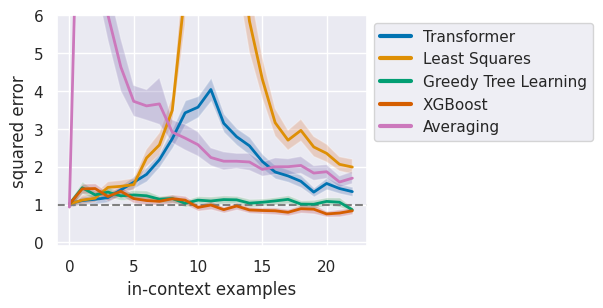

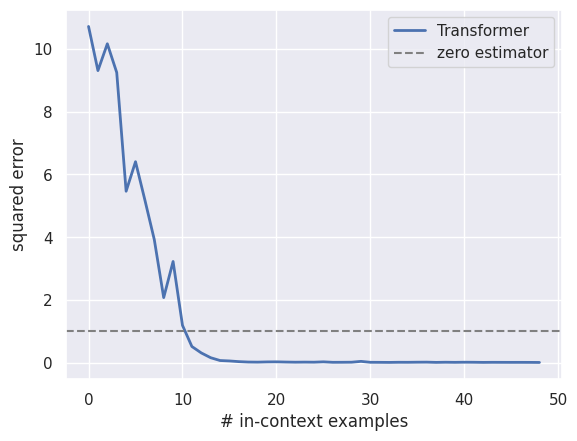

./single/deg2


  0%|          | 0/1 [00:00<?, ?it/s]

['Transformer', 'Least Squares', 'Greedy Tree Learning', 'XGBoost', 'Averaging']
{'standard': {'Transformer': {'mean': [1.0245264226740056, 0.8097324371337891, 0.6686187223954634, 0.5707566087896173, 0.5148086547851562, 0.5002886165272106, 0.38832608136263763, 0.2722335295243697, 0.2663692994551225, 0.17946908690712668, 0.09776954217390581, 0.07499361038208008, 0.03985937346111645, 0.03696045550433072, 0.01774659752845764, 0.012108247388492931, 0.01326869157227603, 0.009555827487598766, 0.007704484191807834, 0.008065854961221868, 0.006415009498596191, 0.0054551423950628805, 0.004811830818653107], 'std': [2.145891709761186, 2.5906672044233843, 1.4034506190906872, 1.3470204093239524, 1.1129881251942029, 1.3882292834195225, 1.3796804601495916, 0.854026967828924, 0.816053650595925, 0.5952843319286, 0.2722747325897217, 0.27934919704090466, 0.11357412555001, 0.24991789731112393, 0.04881599816409024, 0.030613812533291904, 0.04901429198004983, 0.03295674107291482, 0.020885747942057522, 0.03645

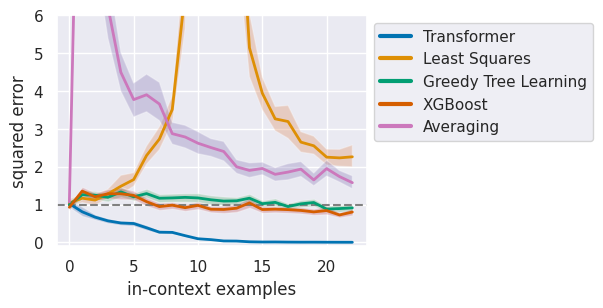

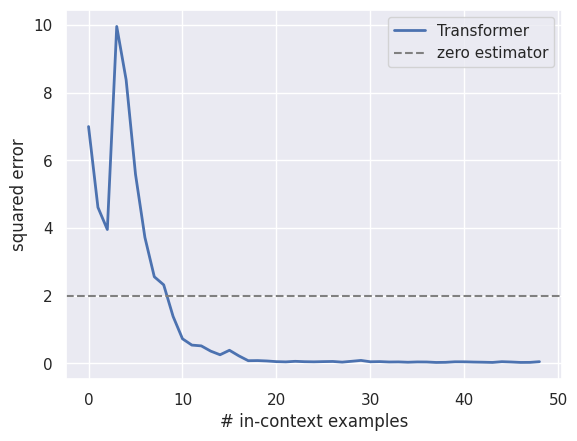

./single/deg3


  0%|          | 0/1 [00:00<?, ?it/s]

['Transformer', 'Least Squares', 'Greedy Tree Learning', 'XGBoost', 'Averaging']
{'standard': {'Transformer': {'mean': [0.9460431012240323, 1.0345304662531072, 1.3547298258001155, 1.8786014210094104, 1.6823928139426492, 2.8422258550470527, 2.743181055242365, 3.433687383478338, 3.7606062455610796, 3.808172746138139, 3.5685358914462, 4.186284498734907, 4.198290738192472, 4.362124009565874, 3.847060116854581, 4.041247974742543, 3.5141109119762075, 3.5085261951793325, 3.219853487881747, 3.109433954412287, 3.406766718084162, 2.8714318708939985, 2.8126270987770776], 'std': [1.8075502569025212, 2.5155466253107246, 3.99447978626598, 5.591543717817827, 4.612288388338956, 10.478253451260654, 10.137274308638139, 11.966941139914773, 12.728517012162643, 13.512164029208096, 9.67482549493963, 13.59927784312855, 12.069818670099432, 12.870955033735795, 10.238345059481533, 11.859440196644176, 11.000776811079545, 12.57948164506392, 9.40522627397017, 8.018547058105469, 12.029488303444602, 10.3337381536310

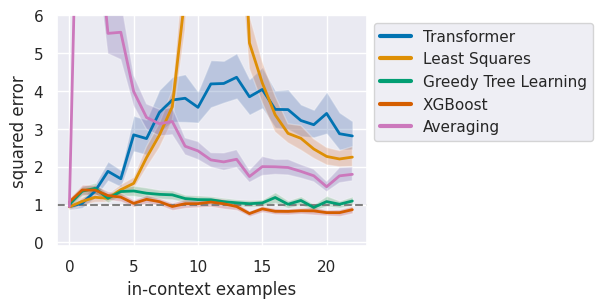

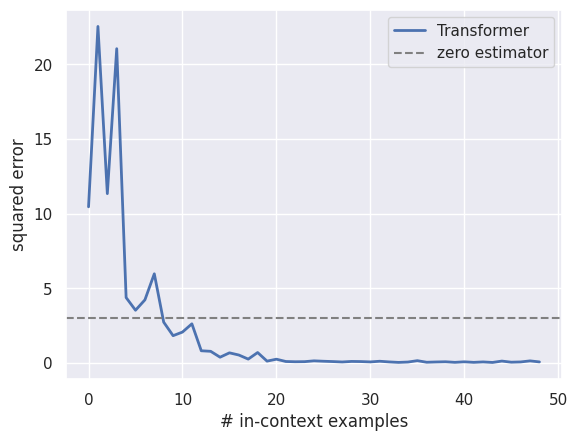

./single/deg5


  0%|          | 0/1 [00:00<?, ?it/s]

['Transformer', 'Least Squares', 'Greedy Tree Learning', 'XGBoost', 'Averaging']
{'standard': {'Transformer': {'mean': [0.9738938591697, 0.8714492971246893, 1.0322145115245471, 0.9398687536066229, 1.0776060277765447, 0.9991153370250355, 0.980084939436479, 0.9762800390070135, 1.0371402393687854, 0.9712824387983843, 0.9822314002297141, 0.9380921450528231, 0.9291393106633966, 0.9776257601651278, 1.0381357019597834, 0.9969917644153942, 0.9945470636541193, 0.9398710944435813, 1.0433731079101562, 0.9811388362537731, 1.0329633192582564, 0.9910340742631392, 1.0304896614768289], 'std': [2.0389529141512783, 1.5350203080610796, 2.1296249736439097, 1.8852533860640093, 2.693287589333274, 2.088170658458363, 1.9140619798140093, 2.1599837216463955, 2.1944625160910864, 2.0138872320001777, 2.4883814725008877, 1.8339379050514915, 1.9305421655828303, 2.1819386915727095, 2.613595962524414, 2.122488195245916, 2.09749360518022, 2.1421690854159268, 2.297021345658736, 2.3051861849698154, 2.199256029996005, 2.1

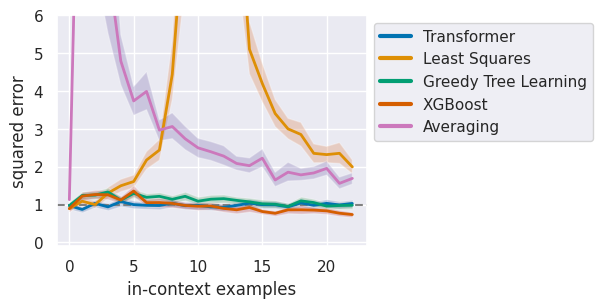

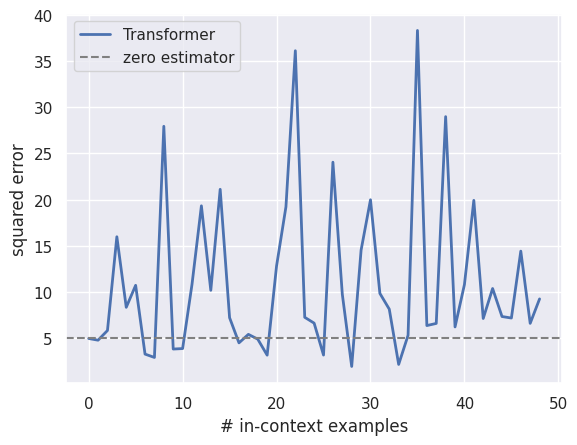

./single/deg10


  0%|          | 0/1 [00:00<?, ?it/s]

['Transformer', 'Least Squares', 'Greedy Tree Learning', 'XGBoost', 'Averaging']
{'standard': {'Transformer': {'mean': [1.1441796909679065, 1.0618481202559038, 0.933713826266202, 0.8739925731312145, 1.0324595191261985, 1.0170494426380505, 0.9860532067038796, 1.0155040567571467, 0.9702872363003817, 1.0332088470458984, 0.867024768482555, 0.8692991950295188, 0.9895513707941229, 1.1232826059514827, 1.046858787536621, 0.9567908373746005, 0.9549714868718927, 0.9172109257091176, 0.9455411217429421, 1.0590631311590022, 0.8428134051236239, 0.924024148420854, 0.988850246776234], 'std': [2.3905135068026455, 2.1934464194557886, 1.9771210063587537, 1.6569052609530361, 2.068269036032937, 2.02280009876598, 2.103925011374734, 2.1830196380615234, 2.176089200106534, 2.3088883486661045, 1.5947487571022727, 1.841401533647017, 2.066381107677113, 3.359407598322088, 2.109929691661488, 2.3760847611860796, 2.111619082364169, 1.82284875349565, 2.325708042491566, 2.151050394231623, 1.6561371196400037, 2.21455279

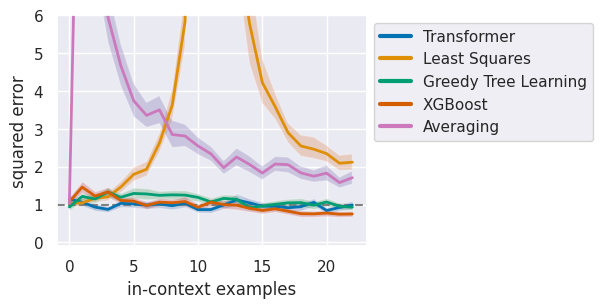

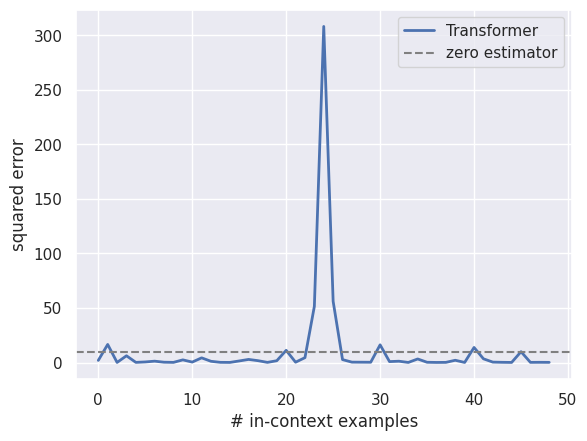

In [25]:
degrees = [1,2,3,5,10]

def get_run_metrics(
    run_path, step=-1, cache=True, skip_model_load=False, skip_baselines=False
):
    if skip_model_load:
        _, conf = get_model_from_run(run_path, only_conf=True)
        all_models = []
    else:
        model, conf = get_model_from_run(run_path, step)
        model = model.cuda().eval()
        all_models = [model]
        if not skip_baselines:
            all_models += get_relevant_baselines(conf.training.task)
    evaluation_kwargs = build_evals(conf)

    if not cache:
        save_path = None
    elif step == -1:
        save_path = os.path.join(run_path, "metrics.json")
    else:
        save_path = os.path.join(run_path, f"metrics_{step}.json")

    recompute = False

    all_metrics = compute_evals(all_models, evaluation_kwargs, save_path, recompute)
    return all_metrics

for i in range(len(degrees)):
    task = "fixed_degree_polynomial_regression"
    args.training.task = task
    args.training.task_kwargs["degree"] = degrees[i]
    # run_path leads to the directory which holds metrics.json and state.pt
    # peer reviewer can just change this and we can upload our compressed data somewhere
    # very low runtime for the rest of the cells
    run_path = "./single/deg"+str(degrees[i])
    recompute_metrics = False

    if recompute_metrics:
        get_run_metrics(run_path)  # these are normally precomputed at the end of training

    metrics = collect_results(run_path, task)
    _, conf = get_model_from_run(run_path, only_conf=True)
    n_dims = conf.model.n_dims

    models = relevant_model_names[task]
    print(models)
    print(metrics)
    basic_plot(metrics["standard"], models=models)
    plt.show()

    # # plot any OOD metrics
    # for name, metric in metrics.items():
    #     if name == "standard": continue

    #     if "scale" in name:
    #         scale = float(name.split("=")[-1])**2
    #     else:
    #         scale = 1.0

    #     trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    #     fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    #     ax.set_title(name)

    #     if "ortho" in name:
    #         ax.set_xlim(-1, n_dims - 1)
    #     ax.set_ylim(-.1 * scale, 1.5 * scale)

    #     plt.show()

    model, conf = get_model_from_run(run_path)

    n_dims = conf.model.n_dims
    batch_size = conf.training.batch_size

    data_sampler = get_data_sampler(conf.training.data, n_dims)
    task_sampler = get_task_sampler(
        conf.training.task,
        n_dims,
        batch_size,
        **conf.training.task_kwargs
    )

    task = task_sampler()
    xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
    ys = task.evaluate(xs)

    with torch.no_grad():
        pred = model(xs, ys)

    metric = task.get_metric()
    loss = metric(pred, ys).numpy()

    sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
    baseline = {
        "fixed_degree_polynomial_regression": args.training.task_kwargs["degree"] if "degree" in args.training.task_kwargs else 0
    }[conf.training.task]

    plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
    plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
    plt.xlabel("# in-context examples")
    plt.ylabel("squared error")
    plt.legend()
    plt.show()

Fixed Degree Polynomial Regression with Standard Deviation Variation

In [26]:
!gdown 1IyURWqN_tuVnKMCnLQadZ05Fay5VejLn
!unzip std_tests

Downloading...
From: https://drive.google.com/uc?id=1IyURWqN_tuVnKMCnLQadZ05Fay5VejLn
To: /content/std_tests.zip
100% 308M/308M [00:02<00:00, 136MB/s]
Archive:  std_tests.zip
   creating: std_tests/deg10_std10/
  inflating: std_tests/deg10_std10/metrics.json  
  inflating: std_tests/deg10_std10/state.pt  
   creating: std_tests/deg10_std5/
  inflating: std_tests/deg10_std5/metrics.json  
  inflating: std_tests/deg10_std5/state.pt  


./std_tests/deg10_std5


  0%|          | 0/1 [00:00<?, ?it/s]

['Transformer', 'Least Squares', 'Greedy Tree Learning', 'XGBoost', 'Averaging']
{'standard': {'Transformer': {'mean': [0.9571828842163086, 0.9769604422829368, 1.088943828235973, 0.9984960556030273, 1.0270743803544478, 1.0595371939919211, 0.955358852039684, 1.0956884730945935, 0.9423587105490945, 1.0102081298828125, 1.0707938454367898, 0.9951146732677113, 0.9665138938210227, 0.9371322285045277, 1.042044379494407, 1.066477515480735, 1.1505374908447266, 0.9111835306340997, 1.0260747562755237, 0.9412983114069159, 0.9940090179443359, 0.9164416573264382, 0.9609932465986772], 'std': [1.9095467654141514, 2.1797570315274326, 2.4039561531760474, 2.2777765447443183, 2.390888214111328, 2.292700680819425, 1.9471463290127842, 2.1940959583629263, 1.8712758150967685, 2.505430221557617, 2.0697337063876065, 2.2943442951549184, 2.360491492531516, 1.9303711977871982, 2.196003653786399, 2.2558359666304155, 2.5360445542769, 1.957789507779208, 2.13351093639027, 2.4390073256059126, 1.9871817502108486, 1.8665

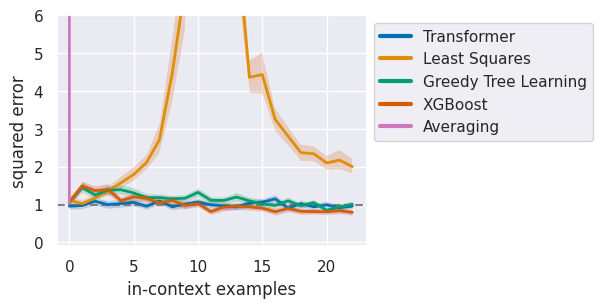

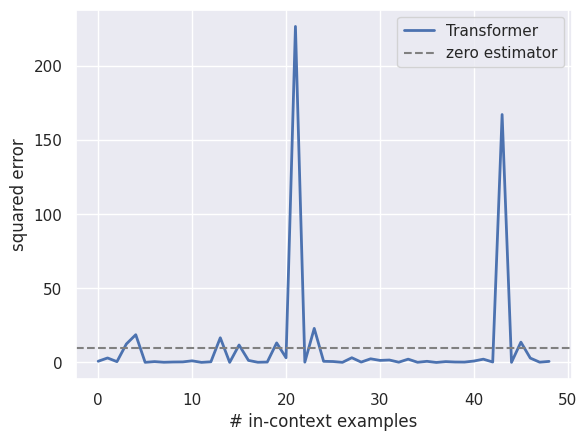

./std_tests/deg10_std10


  0%|          | 0/1 [00:00<?, ?it/s]

['Transformer', 'Least Squares', 'Greedy Tree Learning', 'XGBoost', 'Averaging']
{'standard': {'Transformer': {'mean': [1.0812097029252485, 0.9388079209761186, 0.9399274479259144, 1.044947017322887, 1.0387446663596414, 0.9396176771684126, 0.9473524960604581, 1.0611322576349431, 1.0020863793113015, 0.9141195470636542, 0.9730739593505859, 0.9869394302368164, 1.0307578173550693, 0.9239642403342507, 0.9721425663341176, 1.0622350519353694, 0.9856628938154741, 1.0308690504594282, 0.9853694222190164, 0.898760275407271, 0.9835942008278586, 0.9873756061900746, 1.0017894398082385], 'std': [2.175795468417081, 2.161164023659446, 2.0745221918279473, 2.3498493541370737, 2.33449311689897, 1.8231976249001243, 1.8891279047185725, 2.5144386291503906, 2.133808656172319, 1.8605377890846946, 1.9679575833407315, 2.244092247702859, 2.5878016731955786, 1.8643152063543147, 2.1054113561456855, 2.911897139115767, 2.2310841300270776, 2.2531266645951704, 2.111483487215909, 1.7047507546164773, 2.344084999778054, 2.

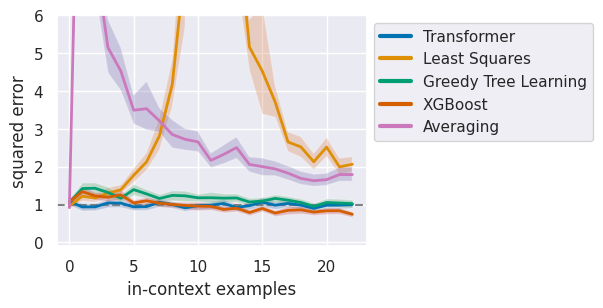

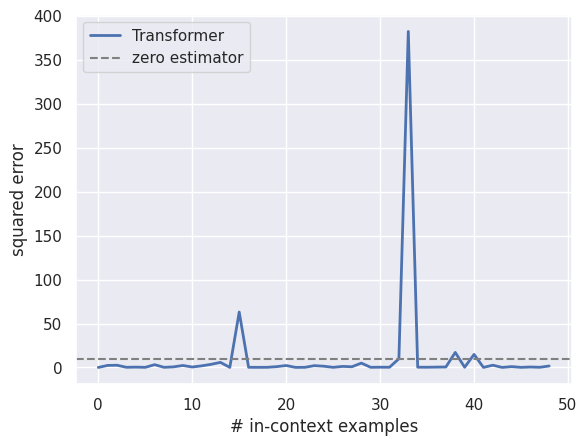

In [28]:
degrees = [5,10]

for i in range(len(degrees)):
    task = "fixed_degree_polynomial_regression"
    args.training.task = task
    args.training.task_kwargs["degree"] = 10
    # run_path leads to the directory which holds metrics.json and state.pt
    # peer reviewer can just change this and we can upload our compressed data somewhere
    # very low runtime for the rest of the cells
    run_path = "./std_tests/deg10_std"+str(degrees[i])
    recompute_metrics = False

    if recompute_metrics:
        get_run_metrics(run_path)  # these are normally precomputed at the end of training

    metrics = collect_results(run_path, task)
    _, conf = get_model_from_run(run_path, only_conf=True)
    n_dims = conf.model.n_dims

    models = relevant_model_names[task]
    print(models)
    print(metrics)
    basic_plot(metrics["standard"], models=models)
    plt.show()

    # # plot any OOD metrics
    # for name, metric in metrics.items():
    #     if name == "standard": continue

    #     if "scale" in name:
    #         scale = float(name.split("=")[-1])**2
    #     else:
    #         scale = 1.0

    #     trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    #     fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    #     ax.set_title(name)

    #     if "ortho" in name:
    #         ax.set_xlim(-1, n_dims - 1)
    #     ax.set_ylim(-.1 * scale, 1.5 * scale)

    #     plt.show()

    model, conf = get_model_from_run(run_path)

    n_dims = conf.model.n_dims
    batch_size = conf.training.batch_size

    data_sampler = get_data_sampler(conf.training.data, n_dims)
    task_sampler = get_task_sampler(
        conf.training.task,
        n_dims,
        batch_size,
        **conf.training.task_kwargs
    )

    task = task_sampler()
    xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
    ys = task.evaluate(xs)

    with torch.no_grad():
        pred = model(xs, ys)

    metric = task.get_metric()
    loss = metric(pred, ys).numpy()

    sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
    baseline = {
        "fixed_degree_polynomial_regression": args.training.task_kwargs["degree"] if "degree" in args.training.task_kwargs else 0
    }[conf.training.task]

    plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
    plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
    plt.xlabel("# in-context examples")
    plt.ylabel("squared error")
    plt.legend()
    plt.show()

Decreasing Degree Polynomial Regression


In [29]:
!gdown 1nxWc5lFkQsAJ_lEnn762igNSfnWRka0O
!unzip descending

Downloading...
From: https://drive.google.com/uc?id=1nxWc5lFkQsAJ_lEnn762igNSfnWRka0O
To: /content/descending.zip
100% 769M/769M [00:03<00:00, 198MB/s]
Archive:  descending.zip
   creating: descending/deg1/
  inflating: descending/deg1/metrics.json  
  inflating: descending/deg1/state.pt  
   creating: descending/deg10/
  inflating: descending/deg10/metrics.json  
  inflating: descending/deg10/state.pt  
   creating: descending/deg2/
  inflating: descending/deg2/metrics.json  
  inflating: descending/deg2/state.pt  
   creating: descending/deg3/
  inflating: descending/deg3/metrics.json  
  inflating: descending/deg3/state.pt  
   creating: descending/deg5/
  inflating: descending/deg5/metrics.json  
  inflating: descending/deg5/state.pt  


./descending/deg1


  0%|          | 0/1 [00:00<?, ?it/s]

['Transformer', 'Least Squares', 'Greedy Tree Learning', 'XGBoost', 'Averaging']
{'standard': {'Transformer': {'mean': [0.9807607477361505, 0.8393043171275746, 0.6601233048872515, 0.7041156942194159, 0.8173125873912465, 0.808569994839755, 0.9311104687777433, 1.0403112931685015, 1.1664955832741477, 1.325420466336337, 1.6554048711603337, 1.8171697096391157, 2.0241192904385654, 1.8348933133212002, 1.3165564970536665, 1.2312207655473189, 1.0926582163030452, 1.0645556883378462, 0.8819781216708097, 0.8669733567671343, 0.9113149642944336, 0.6952678940512917, 0.623825420032848], 'std': [1.6759471893310547, 1.56960730119185, 1.1806325912475586, 1.288268436085094, 1.769871104847301, 1.6887761896306819, 1.8120146664706143, 2.2677478790283203, 2.5887399153275923, 2.5517682162198154, 2.926497372713956, 2.982791553844105, 3.3042550520463423, 2.919838298450817, 2.3839359283447266, 2.138947226784446, 2.284590634432706, 2.2156250693581323, 1.5917578610506924, 1.7481164065274326, 2.0910200639204546, 1.2

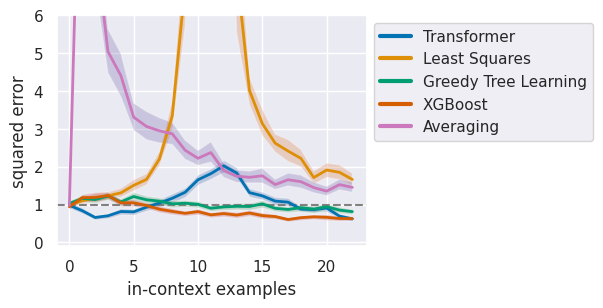

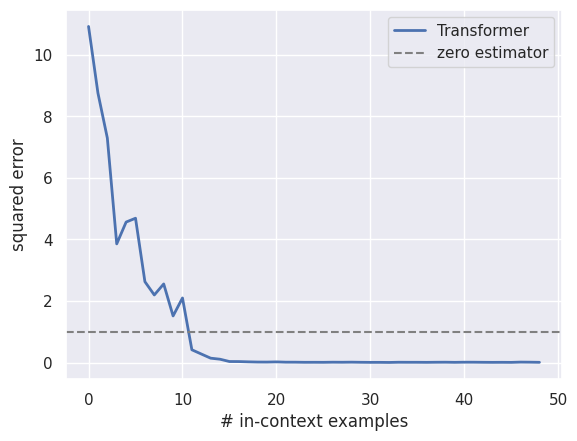

./descending/deg2


  0%|          | 0/1 [00:00<?, ?it/s]

['Transformer', 'Least Squares', 'Greedy Tree Learning', 'XGBoost', 'Averaging']
{'standard': {'Transformer': {'mean': [0.957861293445934, 0.8214747688987039, 0.6951572678305886, 0.6976897499778054, 0.6712089451876554, 0.5515538128939542, 0.505931940945712, 0.507358811118386, 0.4368132677945224, 0.4146718978881836, 0.4252063577825373, 0.3827146183360707, 0.32366332140835846, 0.3231072859330611, 0.28085838664661755, 0.28804768215526233, 0.2412348227067427, 0.24889046495611017, 0.2235457030209628, 0.1838505051352761, 0.18110494180159134, 0.14421227845278653, 0.12899321859533136], 'std': [1.6055353338068181, 1.617679075761275, 1.1052195809104226, 1.3075509504838423, 1.3314903432672673, 1.2934151562777432, 1.075525630604137, 1.0121929862282493, 0.9658297625454989, 0.8403611616654829, 0.9594996192238547, 0.7537179426713423, 0.7549155842174183, 0.7175760269165039, 0.6138007857582786, 0.7025320746681907, 0.5633367191661488, 0.5794295831160112, 0.4515076550570401, 0.4163675308227539, 0.4527073

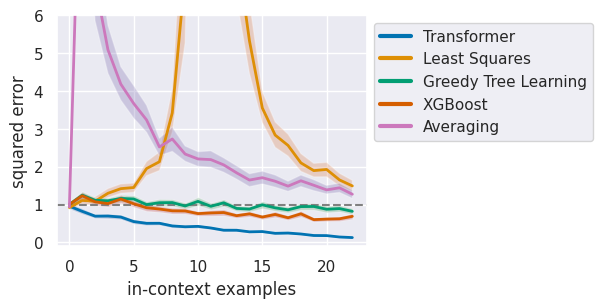

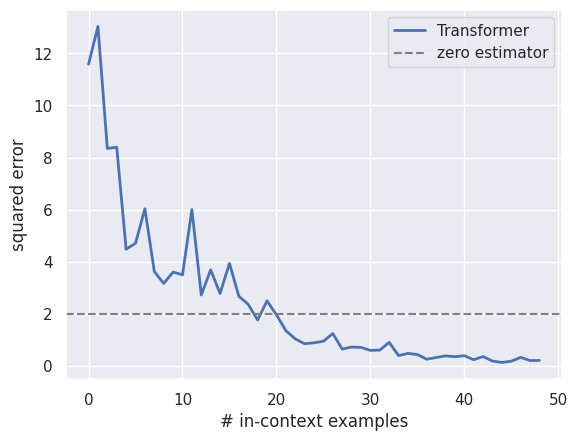

./descending/deg3


  0%|          | 0/1 [00:00<?, ?it/s]

['Transformer', 'Least Squares', 'Greedy Tree Learning', 'XGBoost', 'Averaging']
{'standard': {'Transformer': {'mean': [0.9784523357044567, 0.8499476692893289, 0.8757024244828657, 0.9291070591319691, 0.8126784237948331, 0.7685782692649148, 0.9820530631325461, 0.7495282780040394, 0.7373908649791371, 0.7889637513594194, 0.8030506480823864, 0.6829013390974565, 0.714945836500688, 0.6129398779435591, 0.6716167276555841, 0.7146383632313121, 0.6295746456493031, 0.6908015771345659, 0.5373120307922363, 0.6645966876636852, 0.5550704869357023, 0.6420845551924272, 0.5193063129078258], 'std': [1.7614113200794568, 1.70533596385609, 1.9021065451882102, 2.3388200239701704, 1.7815648859197444, 1.84452993219549, 2.9936471418900923, 1.5680469166148792, 1.7282933321866123, 1.9957523345947266, 2.3753374273126777, 1.5721654024991123, 1.641301761973988, 1.4605641798539595, 1.5049074346368962, 1.9109321941028943, 1.8415220434015447, 2.109153227372603, 1.277675281871449, 1.9418130354447798, 1.3761776143854314,

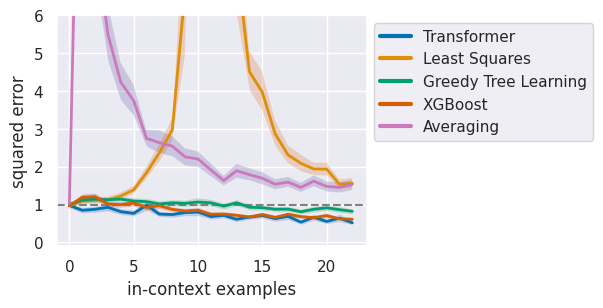

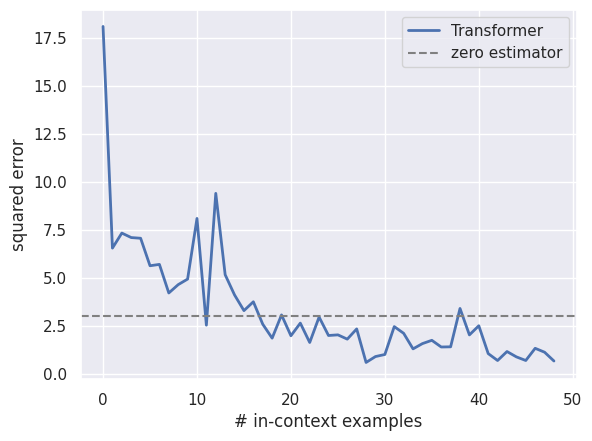

./descending/deg5


  0%|          | 0/1 [00:00<?, ?it/s]

['Transformer', 'Least Squares', 'Greedy Tree Learning', 'XGBoost', 'Averaging']
{'standard': {'Transformer': {'mean': [1.1199712753295898, 0.9099881432273171, 0.962740117853338, 0.9423192631114613, 0.9534378918734464, 0.8884066668423739, 0.9311682961203835, 1.0025434494018555, 0.9349544698541815, 0.8999985781582919, 0.8522229628129439, 0.8530367070978339, 0.9163643230091442, 0.8609006188132546, 0.9016856280240145, 0.8469574668190696, 0.98755559054288, 0.8565824682062323, 0.8409015482122247, 0.8867050517689098, 0.8586145747791637, 0.8622290871360085, 0.802448879588734], 'std': [1.97775598005815, 1.4953327178955078, 1.8747007196599788, 1.9511266188188032, 1.813566728071733, 1.602648301558061, 2.161421689120206, 1.9780576879327947, 1.6522038199684836, 1.7567993510853162, 1.5163605429909446, 1.5383756810968572, 1.708723415027965, 1.4884699041193181, 1.4681493585759944, 1.4365896745161577, 2.0599599318070845, 1.6267032623291016, 1.3903513821688565, 1.6269727186723189, 1.556767550381747, 1.

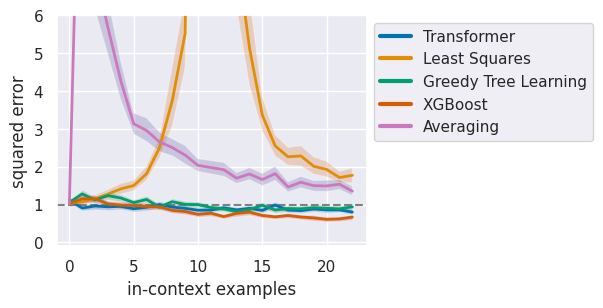

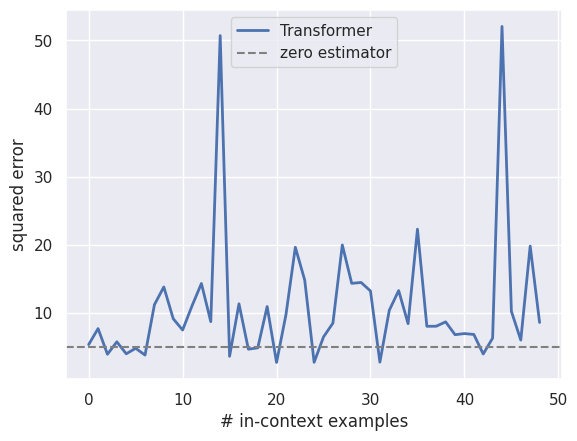

./descending/deg10


  0%|          | 0/1 [00:00<?, ?it/s]

['Transformer', 'Least Squares', 'Greedy Tree Learning', 'XGBoost', 'Averaging']
{'standard': {'Transformer': {'mean': [0.9198129827325995, 1.0167495554143733, 1.029210003939542, 0.9934555400501598, 0.9915025884454901, 0.9688316692005504, 0.9981836839155718, 0.9056501388549805, 1.025721636685458, 1.0264067216352983, 1.1004118485884233, 0.8907502781261097, 0.99335393038663, 0.9460012262517755, 0.9774594740434126, 0.9876055283979936, 1.023972511291504, 1.035217371853915, 1.0309479453346946, 1.074004433371804, 1.0437658483331853, 0.9662304791537198, 1.0150155154141514], 'std': [1.518602891401811, 2.007351962002841, 1.6731130426580256, 1.7130973122336648, 1.874921972101385, 1.64089636369185, 1.6060577739368787, 1.5353449041193181, 1.9567347439852627, 2.002979278564453, 2.025095159357244, 1.5468384135853162, 1.7068679115988992, 1.5112864754416726, 1.6167477694424717, 1.9677144830877131, 1.8587755723433061, 1.7594261169433594, 1.8840044195001775, 1.7980873801491477, 1.7578343478116123, 1.734

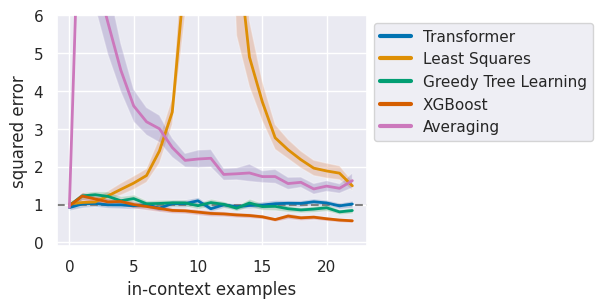

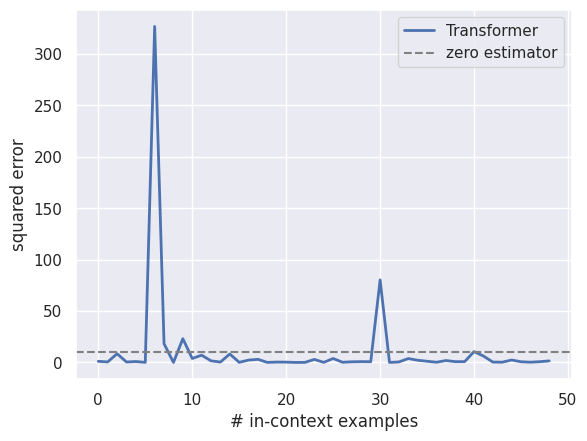

In [32]:
degrees = [1,2,3,5,10]

for i in range(len(degrees)):
    task = "decreasing_degree_polynomial_regression"
    args.training.task = task
    args.training.task_kwargs["degree"] = degrees[i]
    # run_path leads to the directory which holds metrics.json and state.pt
    # peer reviewer can just change this and we can upload our compressed data somewhere
    # very low runtime for the rest of the cells
    run_path = "./descending/deg"+str(degrees[i])
    recompute_metrics = False

    if recompute_metrics:
        get_run_metrics(run_path)  # these are normally precomputed at the end of training

    metrics = collect_results(run_path, task)
    _, conf = get_model_from_run(run_path, only_conf=True)
    n_dims = conf.model.n_dims

    models = relevant_model_names[task]
    print(models)
    print(metrics)
    basic_plot(metrics["standard"], models=models)
    plt.show()

    # # plot any OOD metrics
    # for name, metric in metrics.items():
    #     if name == "standard": continue

    #     if "scale" in name:
    #         scale = float(name.split("=")[-1])**2
    #     else:
    #         scale = 1.0

    #     trivial = 1.0 if "noisy" not in name else (1+1/n_dims)
    #     fig, ax = basic_plot(metric, models=models, trivial=trivial * scale)
    #     ax.set_title(name)

    #     if "ortho" in name:
    #         ax.set_xlim(-1, n_dims - 1)
    #     ax.set_ylim(-.1 * scale, 1.5 * scale)

    #     plt.show()

    model, conf = get_model_from_run(run_path)

    n_dims = conf.model.n_dims
    batch_size = conf.training.batch_size

    data_sampler = get_data_sampler(conf.training.data, n_dims)
    task_sampler = get_task_sampler(
        conf.training.task,
        n_dims,
        batch_size,
        **conf.training.task_kwargs
    )

    task = task_sampler()
    xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf.training.curriculum.points.end)
    ys = task.evaluate(xs)

    with torch.no_grad():
        pred = model(xs, ys)

    metric = task.get_metric()
    loss = metric(pred, ys).numpy()

    sparsity = conf.training.task_kwargs.sparsity if "sparsity" in conf.training.task_kwargs else None
    baseline = {
        "decreasing_degree_polynomial_regression": args.training.task_kwargs["degree"] if "degree" in args.training.task_kwargs else 0
    }[conf.training.task]

    plt.plot(loss.mean(axis=0), lw=2, label="Transformer")
    plt.axhline(baseline, ls="--", color="gray", label="zero estimator")
    plt.xlabel("# in-context examples")
    plt.ylabel("squared error")
    plt.legend()
    plt.show()